In [1]:
import pandas as pd;
import numpy as np;
import matplotlib.pyplot as plt
import numpy as np
import pylab as plt
import plotly.plotly as py
%matplotlib inline

from geopy.geocoders import Nominatim
geolocator = Nominatim()
from geopy.distance import vincenty

import os,sys  
from datetime import datetime
def myfunc(a, b,c,d):
    return mile_to_meter*(vincenty((a,b),(c,d)).miles)
#I also need to vectorize the fucntion to speed up the calculation
vfunc = np.vectorize(myfunc)



In [157]:
#We just want to know the directories of data, which may be usefull in additional run
sub_dir=[]
curr_dir=os.getcwd()+'/'+'data'
for fn in os.listdir(curr_dir):
    sub_dir.append(fn)
sub_dir=np.array(sub_dir)
print("directories of files: ",sub_dir)

#check the number of taxi id files
num_taxi=!ls -al $curr_dir/* |wc -l
print("number of id's of taxi:",num_taxi)

directories of files:  ['013' '07' '011' '09' '08' '014' '012' '06' '010']
number of id's of taxi: ['8934']


In [158]:
#width of bar plot is 12 minutes in time and 8000 meter in distance
tmax=12;
xmax=8000
n_time=24
n_dist=16
bin_time=np.linspace(0,tmax,n_time+1)
bin_dist=np.linspace(0,xmax,n_dist+1)

from datetime import datetime

mile_to_meter=1609.34

#Here i use vincenty function to compute distance between two gps locations

def myfunc(a, b,c,d):
    return mile_to_meter*(vincenty((a,b),(c,d)).miles)
#I also need to vectorize the fucntion to speed up the calculation
vfunc = np.vectorize(myfunc)



tot_time=0
tot_dist=0
tot_trip=0

tot_count_time=np.zeros(n_time)
tot_count_dist=np.zeros(n_dist)

headers =["taxinumber","datetaxi","longitude","lattitude"]
dtypes = {'taxinumber': 'str', 'datetaxi': 'str', 'longitude': 'float', 'lattitude': 'float'}
parse_dates = ['datetaxi']

for idir in range(0,len(sub_dir)):
    #initialize the counting of trips that fall into bins
    count_time=np.zeros(n_time)
    count_dist=np.zeros(n_dist)
    for gn in os.listdir(curr_dir+'/'+sub_dir[idir]):
        dir_gn=curr_dir+'/'+sub_dir[idir]
        filename=dir_gn+'/'+gn
  #      print(filename)

       

        taxi=pd.read_csv(filename,error_bad_lines=False, encoding='utf-8',header=None,names=headers,parse_dates=parse_dates)
        m=taxi.index.size

        
        
        lati=taxi.iloc[0:m-1]['lattitude']
        loni=taxi.iloc[0:m-1]['longitude']

     
        latf=taxi.iloc[1:m]['lattitude']
        lonf=taxi.iloc[1:m]['longitude']
       
        
        
        #check if for a particular taxi  has only 1 data
        if m>1:

            difference=taxi[['datetaxi','longitude','lattitude']].diff(periods=1)
            difference.drop(difference.index[0],inplace=True)
            tot_trip+=difference.index.size

            
            difference['datetaxi']=difference['datetaxi']/(60*np.timedelta64(1,'s'))
            
            #We want to exclude  the travel time >30 minutes
            difference=difference[ difference['datetaxi'] <30 ]
            temp,temp2=np.histogram(difference["datetaxi"],bins=bin_time)
        #   Count the trips that fall into bins
            tot_time+=difference['datetaxi'].sum()
            tot_count_time+=temp
                       
       
            distance=vfunc(lati,loni,latf,lonf)
        # we may want to throw out  the data where traveled distance is larger than 10km
            distance=distance[distance<10000]
            temp_d,temp2=np.histogram(distance,bins=bin_dist)
            tot_count_dist+=temp_d
            
            tot_dist+=np.sum(distance)
               
        
     
        else:     
    #   If the data for a particular taxi only contains 1 line, then dont use the data
            count_time+=0
            count_dist+=0
            tot_trip+=0
        
     #   Because putting all data into one dataframe is impossible, so we compute histogram data for each taxi and combined it later
       
    tot_count_time+=count_time
    tot_count_dist+=count_dist
    #save counting outputs for each directory        
    #print(sub_dir[idir])
    file1=open(sub_dir[idir]+'.dist','w')
    file2=open(sub_dir[idir]+'.time','w')
    
    for i in range(0,len(count_dist)):     
        file1.write(str(count_dist[i])+'\n')
    file1.close()
    for i in range(0,len(count_time)):
        file2.write(str(count_time[i])+'\n')
    file2.close()
    
    #I just want to print out some outputs from each data directory
    print(idir,sub_dir[idir],tot_time,tot_trip,tot_time/tot_trip)
    
         
     
    
print("total number of trips: ",tot_trip)
#print("total amount of time in trips : ",tot_time)
print("average of time in trips",tot_time/tot_trip)
print("average of distance traveled in trips in meter",tot_dist/tot_trip)

#print("total distance (in km)",tot_dist/(1000))


0 013 3995041.933333333 818699 4.8797444889188
1 07 11373383.700000027 2364504 4.8100505222237
2 011 17354778.500000022 3531539 4.914225356140771
3 09 24158788.90000007 4999860 4.831893073006058
4 08 32016514.866666816 6710169 4.7713425498920845
5 014 33028130.183333468 6885487 4.796774750040697
6 012 37538952.10000007 7864564 4.77317650412662
7 06 42015783.70000007 8849985 4.7475542274930485
8 010 46567092.98333351 10079461 4.6199983296064655
total number of trips:  10079461
average of time in trips 4.6199983296064655
average of distance traveled in trips in meter 801.593493154


<Container object of 24 artists>

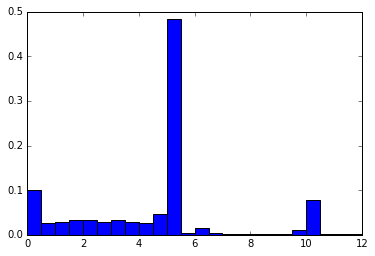

In [262]:
#Plot of time(in minutes) distribution
#The graph is normalized to 1

plt.bar(bin_time[0:n_time],tot_count_time/np.sum(tot_count_time),width=0.5)

<Container object of 16 artists>

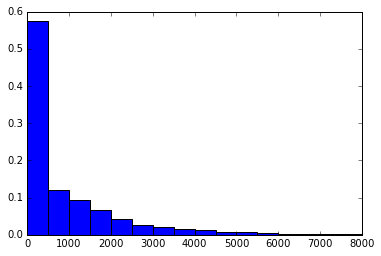

In [5]:
#Plot of distance travelled(in meter) distribution
#The graph is normalized to 1
plt.bar(bin_dist[0:n_dist],tot_count_dist/np.sum(tot_count_dist),width=500)

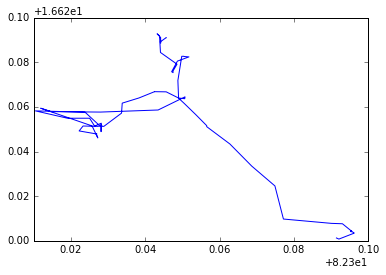

In [6]:
# Just want to show the approximated 2d map of a particular taxi (ID=41)
#X and Y are not correctly scaled

filename=os.getcwd()+'/'+'data/07/41.txt'
headers =["taxinumber","datetaxi","longitude","lattitude"]
dtypes = {'taxinumber': 'str', 'datetaxi': 'str', 'longitude': 'float', 'lattitude': 'float'}
parse_dates = ['datetaxi']
taxi=pd.read_csv(filename,error_bad_lines=False, encoding='utf-8',header=None,names=headers,parse_dates=parse_dates)


#Approximated 2D trajectory
width=100
height=60

x_map = (width) * (180 + taxi['longitude']) / 360
y_map = (height) * (90 - taxi['lattitude']) / 180

x_map=x_map[0:100]
y_map=y_map[0:100]

plt.plot(x_map,y_map)

In [7]:
import gmplot
#Just want to show the trajectory using google map
#Please open mymap.html file


filename=os.getcwd()+'/'+'data/07/98.txt'
headers =["taxinumber","datetaxi","longitude","lattitude"]
dtypes = {'taxinumber': 'str', 'datetaxi': 'str', 'longitude': 'float', 'lattitude': 'float'}
parse_dates = ['datetaxi']
taxi=pd.read_csv(filename,error_bad_lines=False, encoding='utf-8',header=None,names=headers,parse_dates=parse_dates)

gmap = gmplot.GoogleMapPlotter( 39.87268,  116.43859,16)
#Just a fraction of the trajectory
init=100
final=800

latitudes=taxi['lattitude'].iloc[init:final]
longitudes=taxi['longitude'].iloc[init:final]
gmap.plot(latitudes, longitudes, 'cornflowerred', edge_width=10)


gmap.draw("mymap.html")


fitted model: <pykalman.standard.KalmanFilter object at 0x7f9f00a6e6a0>
(100, 2)


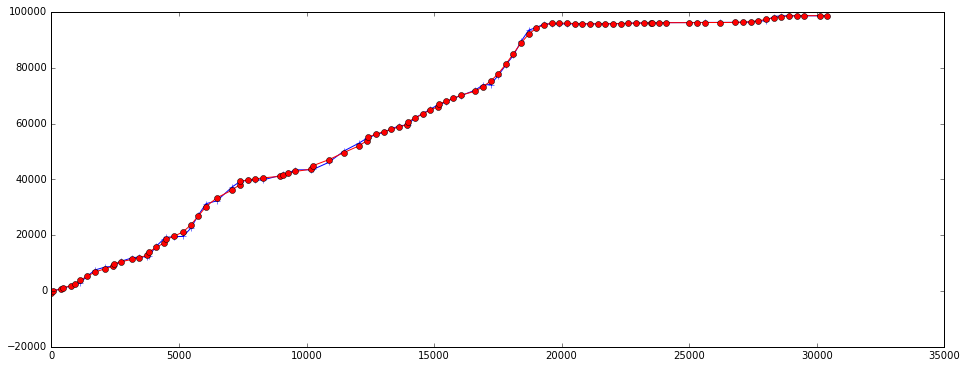

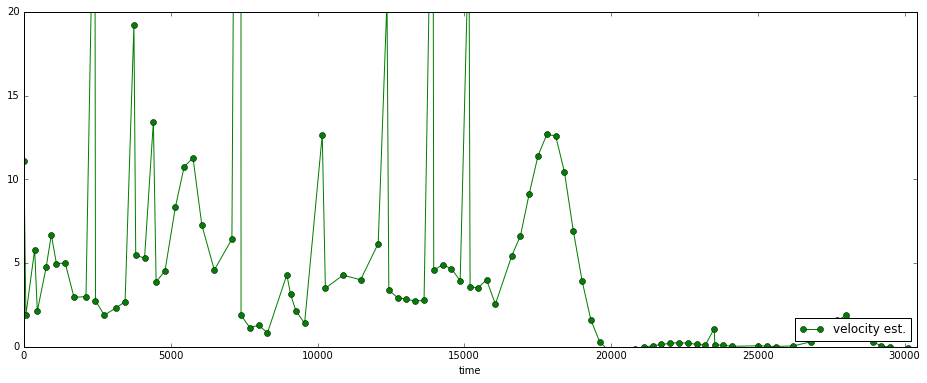

'\nAs we see below, the velocity estimate is not too bad but not good either. This maybe due to unavailability of velocitiy\nmeasurement.\nWe can improve the model to account for constant acceleration\n'

In [160]:
import numpy as np
import pylab as pl

# Let us use kalmanfilter
'''

Kalman filter works with the idea to use both Predictive Dynamics model and data from Measurement , 
and draw estimate from that. 

Ideally i should make a dynamic model that is based also on the paths of the roads( maybe using data from google map).
However i dont know how to import this data from google map.

I tried to approach "making a good model" with idea that taxi has (pretty much) constant magnitude of velocity.
This makes senses, at least constant enough for a fraction of the trajectory.
v=sqrt(vx^2+vy^2) is modeled to be constant

Predictive dynamics model has two variables : (distance travelled) and (velocity)
Observation has only 1 variable             : (GPS locations), which can be converted into (distance travelled)                                       

Here i construct the variables as (distance travelled) and ((delta time)*velocity))
[distance travelled    ](t+dt)    =   (Transition matrix)* [distance travelled    ](t)
[(delta time)*velocity ](t+dt)                             [(delta time)*velocity ](t)

This way i dont need to write transition matrix for each time step (because it is a function of delta time) 
This way, we can construct the transition matrix to be  :np.array([[1, 1], [0, 1]])
           and                 observation matrix to be :np.array([[1, 0], [0, 0]]) -> because no observation for velocity
           

Here i used pykalman package to do the kalman filter and smooothing, no need to rewrite the kalman filter code from scratch
'''

from pykalman import KalmanFilter

n_timesteps = 100
mile_to_meter=1609.34

 
    
filename=os.getcwd()+'/'+'data/07/41.txt'
headers =["taxinumber","datetaxi","longitude","lattitude"]
dtypes = {'taxinumber': 'str', 'datetaxi': 'str', 'longitude': 'float', 'lattitude': 'float'}
parse_dates = ['datetaxi']
taxi=pd.read_csv(filename,error_bad_lines=False, encoding='utf-8',header=None,names=headers,parse_dates=parse_dates)

#We want to do some cleaning of the data with duplicate entries or maybe data that are too close in datetime (less than 5seconds)


listdirty=[]
mt=taxi.index.size
for i in range(0,mt-1):
    delta=(taxi.iloc[i+1]['datetaxi']-taxi.iloc[i]['datetaxi'])/np.timedelta64(1,'s')
    if(delta<5):
        listdirty.append(i+1)

taxi.drop(listdirty,inplace=True)
taxi.reset_index(drop=True,inplace=True)



original=taxi.iloc[0:n_timesteps]['lattitude']

#the x axis will be time (computed from initial point)
x=taxi.iloc[0:n_timesteps]['datetaxi']-taxi.iloc[0]['datetaxi']

#number of data to be plotted
m=n_timesteps


t_new=np.zeros(n_timesteps)
x=x/np.timedelta64(1,'s')
t_newj=x.reset_index(drop=True)
t_newj=np.diff(t_newj)
for i in range(0,n_timesteps-1):
    t_new[i]=t_newj[i]

    
lati=taxi.iloc[0:n_timesteps-1]['lattitude']
loni=taxi.iloc[0:n_timesteps-1]['longitude']
latf=taxi.iloc[1:n_timesteps]['lattitude']
lonf=taxi.iloc[1:n_timesteps]['longitude']
distancex=vfunc(lati,loni,latf,lonf)

#Let us compute distance from original point (t=0)
observations_dist=np.zeros(n_timesteps)
distance=np.append([0],distancex)
for i in range(0,n_timesteps):
    observations_dist[i]=np.sum(distance[0:i+1])
    
observations_vel=np.zeros(n_timesteps)


observations=np.vstack((observations_dist,observations_vel))
observations=np.transpose(observations)


kf = KalmanFilter(transition_matrices=np.array([[1, 1], [0, 1]]),
                  observation_matrices = [[1, 0], [0, 0]],
                  transition_covariance=0.01 * np.eye(2),)

# You can use the Kalman Filter immediately without fitting, but its estimates
# may not be as good as if you fit first.
states_pred = kf.em(observations).smooth(observations)[0]
print('fitted model: {0}'.format(kf))

pl.figure(1)
pl.figure(figsize=(16, 6))

print(np.shape(states_pred))
#Plot of the original data
original_line = pl.plot(x, observations[:,0],
                        linestyle='-', marker='+', color='b',
                        label='observation value.')
                        
                        
position_line = pl.plot(x, states_pred[:, 0],
                        linestyle='-', marker='o', color='r',
                        label='position est.')


pl.figure(2)
pl.figure(figsize=(16, 6))
pl.ylim([0,20])

#We can also try to compute the estimate of the velocity although this is not quite reliable
velocity_line = pl.plot(x, np.divide(states_pred[:, 1],t_new),
                        linestyle='-', marker='o', color='g',
                        label='velocity est.')


pl.legend(loc='lower right')
pl.xlim(xmin=0, xmax=x.max())
pl.xlabel('time')
pl.show()

'''
As we see below, the velocity estimate is not too bad but not good either. This maybe due to unavailability of velocitiy
measurement.
We can improve the model to account for constant acceleration
'''


fitted model: <pykalman.standard.KalmanFilter object at 0x7f9efebda898>


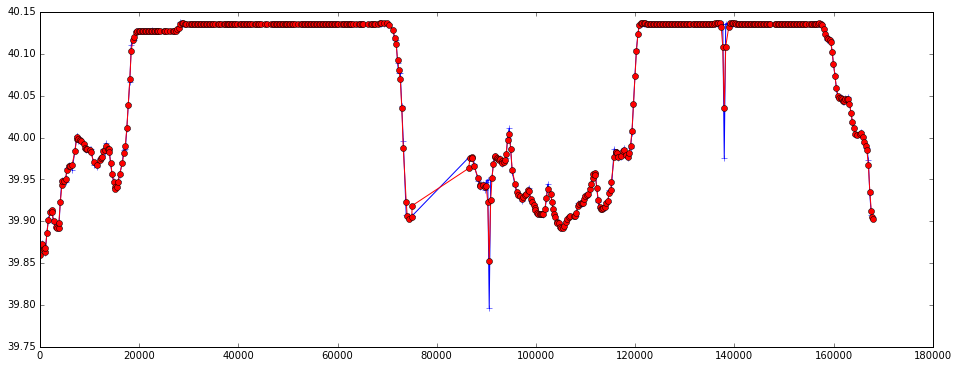

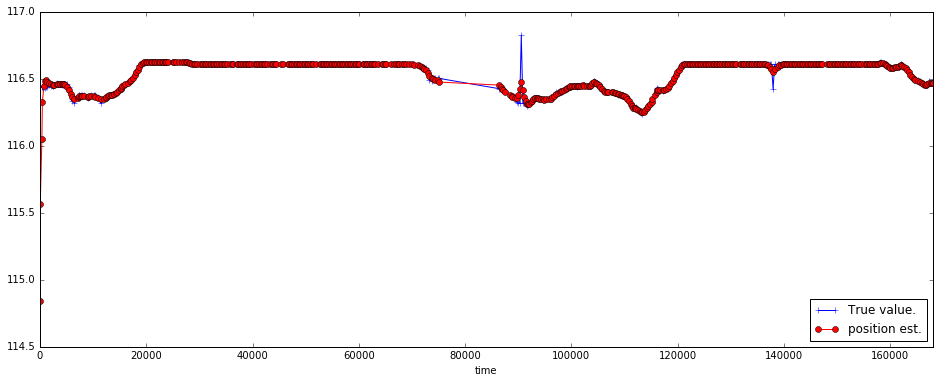

'\nAs we can see below, it takes time for kalman filter to "follow" the measurement of gps\n'

In [257]:
#We can also may try to relax our model,
'''
Let's see what if we start with a model such that vx and vy are pretty much constant
'''

import numpy as np
import pylab as pl

# Let us use kalmanfilter
'''

Predictive dynamics model has two variables : (Lattitude) and (vel lattitude)
Observation only has 1 variable                     : ((Lattitude)                                        

Here i construct the variables as (distance travelled) and ((delta time)*velocity))
[Latttitude    ](t+dt)    =   (Transition matrix)* [Lattitude    ](t)
[vel lattitude     ](t+dt)                         [vel lattitude    ](t)

This way i dont need to write transition matrix for each time step (because it is a function of delta time) 
This way, we can construct the transition matrix to be  :np.array([[1, 1], [0, 1]])
           and                 observation matrix to be :np.array([[1, 0], [0, 0]])
           

'''

from pykalman import KalmanFilter

n_timesteps = 500
mile_to_meter=1609.34

 
    
filename=os.getcwd()+'/'+'data/07/41.txt'
headers =["taxinumber","datetaxi","longitude","lattitude"]
dtypes = {'taxinumber': 'str', 'datetaxi': 'str', 'longitude': 'float', 'lattitude': 'float'}
parse_dates = ['datetaxi']
taxi=pd.read_csv(filename,error_bad_lines=False, encoding='utf-8',header=None,names=headers,parse_dates=parse_dates)

#We want to do some cleaning of the data with duplicate entries or maybe data that are too close in datetime (less than 5seconds)

listdirty=[]
mt=taxi.index.size
for i in range(0,mt-1):
    delta=(taxi.iloc[i+1]['datetaxi']-taxi.iloc[i]['datetaxi'])/np.timedelta64(1,'s')
    if(delta<1):
        listdirty.append(i+1)

taxi.drop(listdirty,inplace=True)
taxi.reset_index(drop=True,inplace=True)



#the x axis will be time (computed from initial point)
x=taxi.iloc[0:n_timesteps]['datetaxi']-taxi.iloc[0]['datetaxi']

#number of data to be plotted
m=n_timesteps


t_new=np.zeros(n_timesteps)
x=x/np.timedelta64(1,'s')
t_newj=x.reset_index(drop=True)
t_newj=np.diff(t_newj)
for i in range(0,n_timesteps-1):
    t_new[i]=t_newj[i]

    
observations_lat=taxi.iloc[0:n_timesteps]['lattitude']
observations_vel=np.zeros(n_timesteps)


observations=np.vstack((observations_lat,observations_vel))
observations=np.transpose(observations)


kf = KalmanFilter(transition_matrices=np.array([[1, 1], [0, 1]]),
                  observation_matrices = [[1, 0], [0, 0]],
                  transition_covariance=0.01 * np.eye(2),)

# You can use the Kalman Filter immediately without fitting, but its estimates
# may not be as good as if you fit first.
states_pred = kf.em(observations).smooth(observations)[0]
Lattitude=states_pred
print('fitted model: {0}'.format(kf))

pl.figure(1)
pl.figure(figsize=(16, 6))

original_line = pl.plot(x, observations[:,0],
                        linestyle='-', marker='+', color='b',
                        label='True value.')
                        
                        
position_line = pl.plot(x, states_pred[:, 0],
                        linestyle='-', marker='o', color='r',
                        label='position est.')



#Lets do the same for longitude  and velocity in longitude direction
pl.figure(2)
pl.figure(figsize=(16, 6))

observations_long=taxi.iloc[0:n_timesteps]['longitude']
observations_vel=np.zeros(n_timesteps)


observations=np.vstack((observations_long,observations_vel))
observations=np.transpose(observations)

kf = KalmanFilter(transition_matrices=np.array([[1, 1], [0, 1]]),
                  observation_matrices = [[1, 0], [0, 0]],
                  transition_covariance=0.01 * np.eye(2),)
states_pred = kf.em(observations).smooth(observations)[0]
Longitude=states_pred
original_line = pl.plot(x, observations[:,0],
                        linestyle='-', marker='+', color='b',
                        label='True value.')
                        
                        
position_line = pl.plot(x, states_pred[:, 0],
                        linestyle='-', marker='o', color='r',
                        label='position est.')








pl.legend(loc='lower right')
pl.xlim(xmin=0, xmax=x.max())
pl.xlabel('time')
pl.show()










'''
As we can see below, it takes time for kalman filter to "follow" the measurement of gps
'''




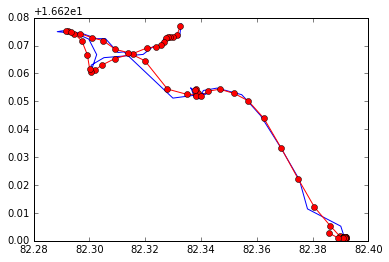

In [273]:

#Approximated smoothened 2D trajectory
width=100
height=60

init=300
final=400

x_map_1 = (width) * (180 + taxi['longitude']) / 360
y_map_1 = (height) * (90 - taxi['lattitude']) / 180

x_map_1=x_map_1[init:final]
y_map_1=y_map_1[init:final]

plt.plot(x_map_1,y_map_1)




x_map_f=(width) * (180 + Longitude[:,0]) / 360
y_map_f = (height) * (90 - Lattitude[:,0]) / 180

plt.plot(x_map_f[init:final],y_map_f[init:final], linestyle='-', marker='o', color='r',
                        label='smoothened')

'''
The dotted are the smoothed trajectory
'''


#Let us see on google map how this loooks like

import gmplot
#Just want to show the trajectory using google map
#Please open mymap.html file

gmap = gmplot.GoogleMapPlotter( 39.87268,  116.43859,16)

latitudes=Lattitude[init:final,0]
longitudes=Longitude[init:final,0]
gmap.plot(latitudes, longitudes, 'cornflowerred', edge_width=10)


gmap.draw("mymap-compare.html")


latitudes=taxi['lattitude'].iloc[init:final]
longitudes=taxi['longitude'].iloc[init:final]
gmap.plot(latitudes, longitudes, 'cornflowerred', edge_width=10)
gmap.draw("mymap-original.html")



In [ ]:
'''
The trajectory may look smoother now(above), but it does not necessarily mean that we are getting closer to the "true trajectory"
because we need to include the path of roads information to get better smoothing result
 
'''